## Hyper - tuning - RF model

The feature space, described below, and the RandomForrest classifier gives us the best validation AUC out of all other models. We will now use `BayesSearchCV` to hyper-tune the classifier on the feature space.

Engineered two different types of features,

1. n_gram similarity between each pair of questions
2. min/max/avg distance between words in a single question. Currently using the following metrics,
  * euclidean
  * cosine
  * city block or manhattan
  
**Pipeline**
1. Stack questions
2. Clean questions - now lower cases all words to better lemmatize proper nouns
3. UNION
    1. n_gram similarity
    2. min/max/avg distance
4. Lemmatize questions
5. UNION
    1. n_gram similarity
    2. min/max/avg distances
6. UNION together both sets of features
7. Random Forrest

**Changes**
* Fix the n_estimators to 500 and search other parameters

In [1]:
# data manipulation
import utils
import pandas as pd
import numpy as np

# modeling
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split

from xgboost import XGBClassifier

# parameter search
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

## Load data

In [2]:
X_train = utils.load('X_train')
y_train = utils.load('y_train')
model_name = 'xgb_hypertune'

## Text transformation and Feature Engineer pipes

In [3]:
# text transformation pipes
clean_text = Pipeline(
    [
        ('stack', FunctionTransformer(utils.stack_questions, validate=False)),
        ('clean', FunctionTransformer(utils.clean_questions, validate=False))

    ]
)

lemma_text = Pipeline(
    [
        ('lemma', FunctionTransformer(utils.apply_lemma, validate=False))
    ]
)

# feature engineering pipes
single_question_pipe = Pipeline(
    [
        ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False)),
        ('unstack', FunctionTransformer(utils.unstack_questions, validate=False))
    ]
)

pair_question_pipe = Pipeline(
    [
        ('ngram_sim', FunctionTransformer(utils.calc_ngram_similarity, kw_args={'n_grams':[1, 2, 3]}, validate=False))
    ]
)

# build features on the cleaned text only
clean_text_features = Pipeline(
    [
        ('clean', clean_text),
        ('feats', FeatureUnion(
            [
                ('pair', pair_question_pipe),
                ('single', single_question_pipe)
            ]
        ))
    ]
)

# build features on the cleanned and lemmatized text features
lemma_text_features = Pipeline(
    [
        ('clean', clean_text),
        ('lemma', lemma_text),
        ('feats', FeatureUnion(
            [
                ('pair', pair_question_pipe),
                ('single', single_question_pipe)
            ]
        ))
    ]
)

# pre-process pipe
feature_transformation = Pipeline(
    [
        ('feats', FeatureUnion(
            [
                ('clean_text_features', clean_text_features),
                ('lemma_text_features', lemma_text_features)
            ]
        ))
    ]
)


In [15]:
%%time
try:
    X_train_transform = utils.load('X_train_transform')
except:
    X_train_transform = feature_transformation.transform(X_train) ## this takes a really long time
    utils.save(X_train_transform, 'X_train_transform')

CPU times: user 64 ms, sys: 40 ms, total: 104 ms
Wall time: 457 ms


## Configure the search

In [11]:
skf = StratifiedKFold(n_splits=3, random_state=42)

# fixed params
xgb_params = {
#     'n_estimators': 584,
    'n_jobs': 4,
    'random_state': 42
}
# XGBClassifier()
# tuning parameters -- start with estimators as I know 500 gives a very good AUC
xgb_search_params = {
    'n_estimators': Integer(500,2000),
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0, 1),
    'gamma': Real(0, 1),
    'reg_lambda': Real(0, 1)
}

bayes_params = {
    'estimator': XGBClassifier(**xgb_params),
    'scoring': 'roc_auc',
    'search_spaces': xgb_search_params,
    'n_iter': 50,
    'cv': skf,
    'n_jobs': 3
}

In [12]:
search_cv = BayesSearchCV(**bayes_params)

## Callbacks

In [13]:
def print_score_progress(optim_results):
    ''' Prints the best score, current score, and current iteration
    '''
    current_results = pd.DataFrame(search_cv.cv_results_)
    print(f'Iteration: {current_results.shape[0]}')
    print(f'Current AUC: {current_results.tail(1).mean_test_score.values[0]:.6f}')
    print(f'Best AUC: {search_cv.best_score_:.6f}')
    print()

def save_best_estimator(optim_results):
    ''' Saves best estimator
    '''
    current_results = pd.DataFrame(search_cv.cv_results_)
    best_score = search_cv.best_score_
    current_score = current_results.tail(1).mean_test_score.values[0]
    if current_score == best_score:
        model = f'tuned_models/{model_name}_{best_score:.6f}'
        print(f'Saving: {model}')
        print()
        utils.save(search_cv, model)

In [16]:
%%time
search_cv_results = search_cv.fit(X_train_transform, y_train, callback=[print_score_progress, save_best_estimator])

Iteration: 1
Current AUC: 0.879244
Best AUC: 0.879244

Saving: tuned_models/xgb_hypertune_0.879244

Iteration: 2
Current AUC: 0.861572
Best AUC: 0.879244

Iteration: 3
Current AUC: 0.884651
Best AUC: 0.884651

Saving: tuned_models/xgb_hypertune_0.884651

Iteration: 4
Current AUC: 0.879053
Best AUC: 0.884651

Iteration: 5
Current AUC: 0.874441
Best AUC: 0.884651

Iteration: 6
Current AUC: 0.873675
Best AUC: 0.884651

Iteration: 7
Current AUC: 0.869050
Best AUC: 0.884651

Iteration: 8
Current AUC: 0.874587
Best AUC: 0.884651

Iteration: 9
Current AUC: 0.881244
Best AUC: 0.884651

Iteration: 10
Current AUC: 0.878754
Best AUC: 0.884651

Iteration: 11
Current AUC: 0.500000
Best AUC: 0.884651

Iteration: 12
Current AUC: 0.500000
Best AUC: 0.884651

Iteration: 13
Current AUC: 0.876083
Best AUC: 0.884651

Iteration: 14
Current AUC: 0.853950
Best AUC: 0.884651

Iteration: 15
Current AUC: 0.863188
Best AUC: 0.884651

Iteration: 16
Current AUC: 0.884341
Best AUC: 0.884651

Iteration: 17
Current A

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [32]:
pd.DataFrame(search_cv_results.cv_results_).sort_values('mean_test_score', ascending=False)

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params
0,0.865546,0.863866,0.866661,0.865357,0.001149,1,299.439168,0.613496,6.363648,0.003194,2,8,692,"{'min_samples_leaf': 2, 'min_samples_split': 8..."
2,0.864886,0.863294,0.866188,0.864789,0.001184,1,256.508619,0.726135,5.458807,0.001653,2,9,596,"{'min_samples_leaf': 2, 'min_samples_split': 9..."
1,0.863357,0.861639,0.864745,0.863247,0.001271,1,263.271633,5.002940,5.527277,0.050183,4,9,619,"{'min_samples_leaf': 4, 'min_samples_split': 9..."


In [28]:
search_cv_results.best_estimator_.get_params() #AUC .868429

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 584,
 'n_jobs': 4,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Best n-estimators: **AUC .868429**

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 584,
 'n_jobs': 4,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
X_t, X_v, y_t, y_v = train_test_split(X_train_transform, y_train, stratify=y_train, random_state=42, test_size = 0.33)

In [36]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=4, random_state=42, verbose=1)

In [37]:
rf.fit(X_t, y_t)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  3.5min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
            oob_score=False, random_state=42, verbose=1, warm_start=False)

In [38]:
y_v_probs = rf.predict_proba(X_v)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    4.9s finished


In [39]:
from sklearn import metrics

In [40]:
metrics.roc_auc_score(y_v, y_v_probs)

0.8689592428199138

## XGB built-in tuning

In [24]:
model = XGBClassifier(n_estimators=5000, random_state=42, n_jobs=-1)


X_t, X_v, y_t, y_v = train_test_split(X_train_transform, y_train, stratify=y_train, random_state=42, test_size = 0.33)

eval_set = [(X_t, y_t), (X_v, y_v)]
eval_metric = ["auc"]
%time model.fit(X_t, y_t, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.752081	validation_1-auc:0.751872
[1]	validation_0-auc:0.777226	validation_1-auc:0.777495
[2]	validation_0-auc:0.784865	validation_1-auc:0.784695
[3]	validation_0-auc:0.785626	validation_1-auc:0.785804
[4]	validation_0-auc:0.786849	validation_1-auc:0.786919
[5]	validation_0-auc:0.786595	validation_1-auc:0.786765
[6]	validation_0-auc:0.786694	validation_1-auc:0.786804
[7]	validation_0-auc:0.786498	validation_1-auc:0.786855
[8]	validation_0-auc:0.786951	validation_1-auc:0.787204
[9]	validation_0-auc:0.787052	validation_1-auc:0.787422
[10]	validation_0-auc:0.787662	validation_1-auc:0.788074
[11]	validation_0-auc:0.787934	validation_1-auc:0.788226
[12]	validation_0-auc:0.788367	validation_1-auc:0.788772
[13]	validation_0-auc:0.788706	validation_1-auc:0.789062
[14]	validation_0-auc:0.789663	validation_1-auc:0.790062
[15]	validation_0-auc:0.789862	validation_1-auc:0.79035
[16]	validation_0-auc:0.791437	validation_1-auc:0.791836
[17]	validation_0-auc:0.792553	validation_

[144]	validation_0-auc:0.828336	validation_1-auc:0.825511
[145]	validation_0-auc:0.828445	validation_1-auc:0.825602
[146]	validation_0-auc:0.828596	validation_1-auc:0.825729
[147]	validation_0-auc:0.82877	validation_1-auc:0.825915
[148]	validation_0-auc:0.828844	validation_1-auc:0.825951
[149]	validation_0-auc:0.828864	validation_1-auc:0.825952
[150]	validation_0-auc:0.829022	validation_1-auc:0.826073
[151]	validation_0-auc:0.829156	validation_1-auc:0.826165
[152]	validation_0-auc:0.829215	validation_1-auc:0.826213
[153]	validation_0-auc:0.829317	validation_1-auc:0.826341
[154]	validation_0-auc:0.829464	validation_1-auc:0.826426
[155]	validation_0-auc:0.82953	validation_1-auc:0.826456
[156]	validation_0-auc:0.829626	validation_1-auc:0.826501
[157]	validation_0-auc:0.829731	validation_1-auc:0.826605
[158]	validation_0-auc:0.829816	validation_1-auc:0.826676
[159]	validation_0-auc:0.830001	validation_1-auc:0.826849
[160]	validation_0-auc:0.830085	validation_1-auc:0.826929
[161]	validation

[286]	validation_0-auc:0.842817	validation_1-auc:0.837278
[287]	validation_0-auc:0.842908	validation_1-auc:0.837382
[288]	validation_0-auc:0.843014	validation_1-auc:0.837478
[289]	validation_0-auc:0.843095	validation_1-auc:0.837521
[290]	validation_0-auc:0.843179	validation_1-auc:0.837603
[291]	validation_0-auc:0.843272	validation_1-auc:0.837705
[292]	validation_0-auc:0.84337	validation_1-auc:0.83777
[293]	validation_0-auc:0.843429	validation_1-auc:0.837817
[294]	validation_0-auc:0.843461	validation_1-auc:0.837827
[295]	validation_0-auc:0.843496	validation_1-auc:0.837854
[296]	validation_0-auc:0.84355	validation_1-auc:0.837869
[297]	validation_0-auc:0.843586	validation_1-auc:0.837887
[298]	validation_0-auc:0.843669	validation_1-auc:0.837966
[299]	validation_0-auc:0.843796	validation_1-auc:0.838054
[300]	validation_0-auc:0.843965	validation_1-auc:0.838186
[301]	validation_0-auc:0.844024	validation_1-auc:0.838256
[302]	validation_0-auc:0.844077	validation_1-auc:0.838292
[303]	validation_

[428]	validation_0-auc:0.852261	validation_1-auc:0.844594
[429]	validation_0-auc:0.852365	validation_1-auc:0.844675
[430]	validation_0-auc:0.852461	validation_1-auc:0.844764
[431]	validation_0-auc:0.852525	validation_1-auc:0.844821
[432]	validation_0-auc:0.852535	validation_1-auc:0.844846
[433]	validation_0-auc:0.852609	validation_1-auc:0.844906
[434]	validation_0-auc:0.852701	validation_1-auc:0.844991
[435]	validation_0-auc:0.852774	validation_1-auc:0.845053
[436]	validation_0-auc:0.852805	validation_1-auc:0.845075
[437]	validation_0-auc:0.852846	validation_1-auc:0.84513
[438]	validation_0-auc:0.852994	validation_1-auc:0.845252
[439]	validation_0-auc:0.853071	validation_1-auc:0.84532
[440]	validation_0-auc:0.853087	validation_1-auc:0.845327
[441]	validation_0-auc:0.853161	validation_1-auc:0.845392
[442]	validation_0-auc:0.853217	validation_1-auc:0.845414
[443]	validation_0-auc:0.853322	validation_1-auc:0.845503
[444]	validation_0-auc:0.853417	validation_1-auc:0.845589
[445]	validation

[570]	validation_0-auc:0.859122	validation_1-auc:0.849397
[571]	validation_0-auc:0.859139	validation_1-auc:0.849399
[572]	validation_0-auc:0.859148	validation_1-auc:0.849405
[573]	validation_0-auc:0.859168	validation_1-auc:0.849421
[574]	validation_0-auc:0.859188	validation_1-auc:0.849428
[575]	validation_0-auc:0.859221	validation_1-auc:0.849448
[576]	validation_0-auc:0.859302	validation_1-auc:0.849508
[577]	validation_0-auc:0.859351	validation_1-auc:0.849559
[578]	validation_0-auc:0.859413	validation_1-auc:0.849596
[579]	validation_0-auc:0.859494	validation_1-auc:0.849657
[580]	validation_0-auc:0.859544	validation_1-auc:0.849686
[581]	validation_0-auc:0.859575	validation_1-auc:0.849707
[582]	validation_0-auc:0.85965	validation_1-auc:0.849771
[583]	validation_0-auc:0.859727	validation_1-auc:0.849838
[584]	validation_0-auc:0.859787	validation_1-auc:0.849874
[585]	validation_0-auc:0.859818	validation_1-auc:0.849879
[586]	validation_0-auc:0.859864	validation_1-auc:0.849905
[587]	validatio

[712]	validation_0-auc:0.864609	validation_1-auc:0.852993
[713]	validation_0-auc:0.864645	validation_1-auc:0.853025
[714]	validation_0-auc:0.864681	validation_1-auc:0.853048
[715]	validation_0-auc:0.864707	validation_1-auc:0.853055
[716]	validation_0-auc:0.864752	validation_1-auc:0.853097
[717]	validation_0-auc:0.864798	validation_1-auc:0.853134
[718]	validation_0-auc:0.864817	validation_1-auc:0.853154
[719]	validation_0-auc:0.864893	validation_1-auc:0.853215
[720]	validation_0-auc:0.864912	validation_1-auc:0.85323
[721]	validation_0-auc:0.864919	validation_1-auc:0.853232
[722]	validation_0-auc:0.864946	validation_1-auc:0.853241
[723]	validation_0-auc:0.864982	validation_1-auc:0.85326
[724]	validation_0-auc:0.865016	validation_1-auc:0.853271
[725]	validation_0-auc:0.865046	validation_1-auc:0.853299
[726]	validation_0-auc:0.865069	validation_1-auc:0.853316
[727]	validation_0-auc:0.865143	validation_1-auc:0.853379
[728]	validation_0-auc:0.865167	validation_1-auc:0.853392
[729]	validation

[854]	validation_0-auc:0.869117	validation_1-auc:0.85553
[855]	validation_0-auc:0.869159	validation_1-auc:0.855566
[856]	validation_0-auc:0.869193	validation_1-auc:0.855595
[857]	validation_0-auc:0.869211	validation_1-auc:0.855597
[858]	validation_0-auc:0.869247	validation_1-auc:0.855603
[859]	validation_0-auc:0.869281	validation_1-auc:0.85562
[860]	validation_0-auc:0.86932	validation_1-auc:0.855653
[861]	validation_0-auc:0.869353	validation_1-auc:0.855659
[862]	validation_0-auc:0.869371	validation_1-auc:0.855663
[863]	validation_0-auc:0.869386	validation_1-auc:0.855668
[864]	validation_0-auc:0.869412	validation_1-auc:0.855675
[865]	validation_0-auc:0.869443	validation_1-auc:0.855684
[866]	validation_0-auc:0.869469	validation_1-auc:0.855696
[867]	validation_0-auc:0.869488	validation_1-auc:0.855701
[868]	validation_0-auc:0.869509	validation_1-auc:0.855708
[869]	validation_0-auc:0.869554	validation_1-auc:0.855727
[870]	validation_0-auc:0.869578	validation_1-auc:0.855732
[871]	validation_

[996]	validation_0-auc:0.87316	validation_1-auc:0.857639
[997]	validation_0-auc:0.873204	validation_1-auc:0.857683
[998]	validation_0-auc:0.873233	validation_1-auc:0.857695
[999]	validation_0-auc:0.873275	validation_1-auc:0.857727
[1000]	validation_0-auc:0.873291	validation_1-auc:0.857736
[1001]	validation_0-auc:0.873332	validation_1-auc:0.857747
[1002]	validation_0-auc:0.873363	validation_1-auc:0.857773
[1003]	validation_0-auc:0.873381	validation_1-auc:0.85779
[1004]	validation_0-auc:0.873419	validation_1-auc:0.857802
[1005]	validation_0-auc:0.873455	validation_1-auc:0.857821
[1006]	validation_0-auc:0.873478	validation_1-auc:0.857836
[1007]	validation_0-auc:0.8735	validation_1-auc:0.857842
[1008]	validation_0-auc:0.873513	validation_1-auc:0.857846
[1009]	validation_0-auc:0.873541	validation_1-auc:0.857853
[1010]	validation_0-auc:0.873556	validation_1-auc:0.857857
[1011]	validation_0-auc:0.873573	validation_1-auc:0.857857
[1012]	validation_0-auc:0.873596	validation_1-auc:0.857859
[1013

[1136]	validation_0-auc:0.876719	validation_1-auc:0.859293
[1137]	validation_0-auc:0.876736	validation_1-auc:0.859293
[1138]	validation_0-auc:0.876761	validation_1-auc:0.859297
[1139]	validation_0-auc:0.876789	validation_1-auc:0.859317
[1140]	validation_0-auc:0.876859	validation_1-auc:0.859358
[1141]	validation_0-auc:0.876883	validation_1-auc:0.85938
[1142]	validation_0-auc:0.876911	validation_1-auc:0.85938
[1143]	validation_0-auc:0.876931	validation_1-auc:0.859387
[1144]	validation_0-auc:0.876955	validation_1-auc:0.859406
[1145]	validation_0-auc:0.876964	validation_1-auc:0.859406
[1146]	validation_0-auc:0.876994	validation_1-auc:0.859437
[1147]	validation_0-auc:0.877021	validation_1-auc:0.85944
[1148]	validation_0-auc:0.87703	validation_1-auc:0.859438
[1149]	validation_0-auc:0.877049	validation_1-auc:0.859447
[1150]	validation_0-auc:0.877096	validation_1-auc:0.859473
[1151]	validation_0-auc:0.87711	validation_1-auc:0.859465
[1152]	validation_0-auc:0.877119	validation_1-auc:0.859473
[1

[1276]	validation_0-auc:0.880029	validation_1-auc:0.860979
[1277]	validation_0-auc:0.880058	validation_1-auc:0.860982
[1278]	validation_0-auc:0.880083	validation_1-auc:0.860989
[1279]	validation_0-auc:0.88011	validation_1-auc:0.860993
[1280]	validation_0-auc:0.880134	validation_1-auc:0.861019
[1281]	validation_0-auc:0.880157	validation_1-auc:0.861039
[1282]	validation_0-auc:0.880198	validation_1-auc:0.861075
[1283]	validation_0-auc:0.880226	validation_1-auc:0.861092
[1284]	validation_0-auc:0.880261	validation_1-auc:0.861101
[1285]	validation_0-auc:0.880291	validation_1-auc:0.861117
[1286]	validation_0-auc:0.880315	validation_1-auc:0.861126
[1287]	validation_0-auc:0.880338	validation_1-auc:0.861136
[1288]	validation_0-auc:0.880363	validation_1-auc:0.861143
[1289]	validation_0-auc:0.880373	validation_1-auc:0.861142
[1290]	validation_0-auc:0.880402	validation_1-auc:0.861167
[1291]	validation_0-auc:0.880423	validation_1-auc:0.86118
[1292]	validation_0-auc:0.880441	validation_1-auc:0.861197

[1416]	validation_0-auc:0.882986	validation_1-auc:0.86221
[1417]	validation_0-auc:0.882997	validation_1-auc:0.862205
[1418]	validation_0-auc:0.883017	validation_1-auc:0.86221
[1419]	validation_0-auc:0.883051	validation_1-auc:0.86224
[1420]	validation_0-auc:0.883066	validation_1-auc:0.862244
[1421]	validation_0-auc:0.883084	validation_1-auc:0.862246
[1422]	validation_0-auc:0.883104	validation_1-auc:0.862257
[1423]	validation_0-auc:0.883112	validation_1-auc:0.862257
[1424]	validation_0-auc:0.883128	validation_1-auc:0.862264
[1425]	validation_0-auc:0.883146	validation_1-auc:0.86227
[1426]	validation_0-auc:0.883178	validation_1-auc:0.862282
[1427]	validation_0-auc:0.883194	validation_1-auc:0.862282
[1428]	validation_0-auc:0.883209	validation_1-auc:0.86228
[1429]	validation_0-auc:0.883225	validation_1-auc:0.862281
[1430]	validation_0-auc:0.883236	validation_1-auc:0.862283
[1431]	validation_0-auc:0.88325	validation_1-auc:0.86228
[1432]	validation_0-auc:0.88326	validation_1-auc:0.862284
[1433

[1556]	validation_0-auc:0.885754	validation_1-auc:0.863362
[1557]	validation_0-auc:0.88577	validation_1-auc:0.863364
[1558]	validation_0-auc:0.885805	validation_1-auc:0.863388
[1559]	validation_0-auc:0.885818	validation_1-auc:0.863384
[1560]	validation_0-auc:0.885827	validation_1-auc:0.863385
[1561]	validation_0-auc:0.885879	validation_1-auc:0.863423
[1562]	validation_0-auc:0.885912	validation_1-auc:0.863439
[1563]	validation_0-auc:0.885919	validation_1-auc:0.863446
[1564]	validation_0-auc:0.885929	validation_1-auc:0.863449
[1565]	validation_0-auc:0.885955	validation_1-auc:0.863458
[1566]	validation_0-auc:0.885981	validation_1-auc:0.863472
[1567]	validation_0-auc:0.885998	validation_1-auc:0.863485
[1568]	validation_0-auc:0.886017	validation_1-auc:0.863493
[1569]	validation_0-auc:0.886043	validation_1-auc:0.863499
[1570]	validation_0-auc:0.88605	validation_1-auc:0.863497
[1571]	validation_0-auc:0.886064	validation_1-auc:0.863503
[1572]	validation_0-auc:0.886075	validation_1-auc:0.863499

[1696]	validation_0-auc:0.888457	validation_1-auc:0.864482
[1697]	validation_0-auc:0.88848	validation_1-auc:0.864489
[1698]	validation_0-auc:0.888494	validation_1-auc:0.864491
[1699]	validation_0-auc:0.888503	validation_1-auc:0.864488
[1700]	validation_0-auc:0.888517	validation_1-auc:0.864502
[1701]	validation_0-auc:0.888533	validation_1-auc:0.864509
[1702]	validation_0-auc:0.888544	validation_1-auc:0.864508
[1703]	validation_0-auc:0.888567	validation_1-auc:0.864526
[1704]	validation_0-auc:0.888575	validation_1-auc:0.864532
[1705]	validation_0-auc:0.888594	validation_1-auc:0.864528
[1706]	validation_0-auc:0.888613	validation_1-auc:0.86454
[1707]	validation_0-auc:0.888627	validation_1-auc:0.864546
[1708]	validation_0-auc:0.888654	validation_1-auc:0.864552
[1709]	validation_0-auc:0.88867	validation_1-auc:0.864557
[1710]	validation_0-auc:0.88869	validation_1-auc:0.864569
[1711]	validation_0-auc:0.888717	validation_1-auc:0.864586
[1712]	validation_0-auc:0.888735	validation_1-auc:0.864591
[

[1836]	validation_0-auc:0.891014	validation_1-auc:0.865296
[1837]	validation_0-auc:0.891029	validation_1-auc:0.865314
[1838]	validation_0-auc:0.89105	validation_1-auc:0.865317
[1839]	validation_0-auc:0.891059	validation_1-auc:0.865323
[1840]	validation_0-auc:0.891081	validation_1-auc:0.86533
[1841]	validation_0-auc:0.891123	validation_1-auc:0.865346
[1842]	validation_0-auc:0.891141	validation_1-auc:0.865359
[1843]	validation_0-auc:0.891154	validation_1-auc:0.865364
[1844]	validation_0-auc:0.891171	validation_1-auc:0.865364
[1845]	validation_0-auc:0.891176	validation_1-auc:0.86536
[1846]	validation_0-auc:0.891195	validation_1-auc:0.865351
[1847]	validation_0-auc:0.891216	validation_1-auc:0.865356
[1848]	validation_0-auc:0.891234	validation_1-auc:0.865369
[1849]	validation_0-auc:0.89125	validation_1-auc:0.865374
[1850]	validation_0-auc:0.89127	validation_1-auc:0.865399
[1851]	validation_0-auc:0.891284	validation_1-auc:0.865409
[1852]	validation_0-auc:0.891313	validation_1-auc:0.865426
[1

[1976]	validation_0-auc:0.893392	validation_1-auc:0.866246
[1977]	validation_0-auc:0.893423	validation_1-auc:0.866258
[1978]	validation_0-auc:0.893442	validation_1-auc:0.866259
[1979]	validation_0-auc:0.893442	validation_1-auc:0.866267
[1980]	validation_0-auc:0.893454	validation_1-auc:0.866279
[1981]	validation_0-auc:0.893468	validation_1-auc:0.866284
[1982]	validation_0-auc:0.893497	validation_1-auc:0.866302
[1983]	validation_0-auc:0.893524	validation_1-auc:0.866306
[1984]	validation_0-auc:0.893544	validation_1-auc:0.866307
[1985]	validation_0-auc:0.893564	validation_1-auc:0.86631
[1986]	validation_0-auc:0.893591	validation_1-auc:0.86632
[1987]	validation_0-auc:0.893609	validation_1-auc:0.866328
[1988]	validation_0-auc:0.893618	validation_1-auc:0.866323
[1989]	validation_0-auc:0.893624	validation_1-auc:0.866327
[1990]	validation_0-auc:0.893644	validation_1-auc:0.86633
[1991]	validation_0-auc:0.893656	validation_1-auc:0.866341
[1992]	validation_0-auc:0.893654	validation_1-auc:0.86634
[

[2116]	validation_0-auc:0.895854	validation_1-auc:0.867284
[2117]	validation_0-auc:0.895858	validation_1-auc:0.867284
[2118]	validation_0-auc:0.895872	validation_1-auc:0.867309
[2119]	validation_0-auc:0.895895	validation_1-auc:0.867329
[2120]	validation_0-auc:0.895914	validation_1-auc:0.867329
[2121]	validation_0-auc:0.895932	validation_1-auc:0.867332
[2122]	validation_0-auc:0.895948	validation_1-auc:0.867335
[2123]	validation_0-auc:0.895967	validation_1-auc:0.867339
[2124]	validation_0-auc:0.895988	validation_1-auc:0.867346
[2125]	validation_0-auc:0.896	validation_1-auc:0.86734
[2126]	validation_0-auc:0.896021	validation_1-auc:0.867355
[2127]	validation_0-auc:0.896032	validation_1-auc:0.867362
[2128]	validation_0-auc:0.896054	validation_1-auc:0.867361
[2129]	validation_0-auc:0.89607	validation_1-auc:0.86736
[2130]	validation_0-auc:0.89607	validation_1-auc:0.867359
[2131]	validation_0-auc:0.896076	validation_1-auc:0.867355
[2132]	validation_0-auc:0.896089	validation_1-auc:0.86737
[2133

[2256]	validation_0-auc:0.897969	validation_1-auc:0.868074
[2257]	validation_0-auc:0.897984	validation_1-auc:0.868075
[2258]	validation_0-auc:0.898014	validation_1-auc:0.868089
[2259]	validation_0-auc:0.89803	validation_1-auc:0.868092
[2260]	validation_0-auc:0.898031	validation_1-auc:0.868093
[2261]	validation_0-auc:0.898044	validation_1-auc:0.868102
[2262]	validation_0-auc:0.898053	validation_1-auc:0.868102
[2263]	validation_0-auc:0.898069	validation_1-auc:0.86811
[2264]	validation_0-auc:0.898086	validation_1-auc:0.868118
[2265]	validation_0-auc:0.898097	validation_1-auc:0.86812
[2266]	validation_0-auc:0.898112	validation_1-auc:0.868129
[2267]	validation_0-auc:0.898121	validation_1-auc:0.86813
[2268]	validation_0-auc:0.898133	validation_1-auc:0.868136
[2269]	validation_0-auc:0.898155	validation_1-auc:0.868141
[2270]	validation_0-auc:0.898176	validation_1-auc:0.868137
[2271]	validation_0-auc:0.898182	validation_1-auc:0.868137
[2272]	validation_0-auc:0.898191	validation_1-auc:0.86815
[2

[2396]	validation_0-auc:0.90024	validation_1-auc:0.868999
[2397]	validation_0-auc:0.900263	validation_1-auc:0.869006
[2398]	validation_0-auc:0.900288	validation_1-auc:0.869019
[2399]	validation_0-auc:0.900295	validation_1-auc:0.869033
[2400]	validation_0-auc:0.900316	validation_1-auc:0.869047
[2401]	validation_0-auc:0.900339	validation_1-auc:0.869045
[2402]	validation_0-auc:0.90036	validation_1-auc:0.86905
[2403]	validation_0-auc:0.900386	validation_1-auc:0.869065
[2404]	validation_0-auc:0.900396	validation_1-auc:0.869067
[2405]	validation_0-auc:0.900408	validation_1-auc:0.869073
[2406]	validation_0-auc:0.900424	validation_1-auc:0.869079
[2407]	validation_0-auc:0.900433	validation_1-auc:0.869074
[2408]	validation_0-auc:0.900445	validation_1-auc:0.869084
[2409]	validation_0-auc:0.900462	validation_1-auc:0.869093
[2410]	validation_0-auc:0.900477	validation_1-auc:0.869097
[2411]	validation_0-auc:0.900491	validation_1-auc:0.869099
[2412]	validation_0-auc:0.900506	validation_1-auc:0.8691
[2

[2536]	validation_0-auc:0.902216	validation_1-auc:0.869657
[2537]	validation_0-auc:0.902248	validation_1-auc:0.869675
[2538]	validation_0-auc:0.902254	validation_1-auc:0.869674
[2539]	validation_0-auc:0.90227	validation_1-auc:0.869676
[2540]	validation_0-auc:0.902273	validation_1-auc:0.869675
[2541]	validation_0-auc:0.9023	validation_1-auc:0.869685
[2542]	validation_0-auc:0.902316	validation_1-auc:0.8697
[2543]	validation_0-auc:0.902335	validation_1-auc:0.869701
[2544]	validation_0-auc:0.902359	validation_1-auc:0.869712
[2545]	validation_0-auc:0.902379	validation_1-auc:0.86971
[2546]	validation_0-auc:0.902396	validation_1-auc:0.869707
[2547]	validation_0-auc:0.902403	validation_1-auc:0.869706
[2548]	validation_0-auc:0.902414	validation_1-auc:0.869703
[2549]	validation_0-auc:0.90243	validation_1-auc:0.869709
[2550]	validation_0-auc:0.902433	validation_1-auc:0.86971
[2551]	validation_0-auc:0.902438	validation_1-auc:0.869709
[2552]	validation_0-auc:0.902447	validation_1-auc:0.869705
[2553

[2676]	validation_0-auc:0.904135	validation_1-auc:0.870223
[2677]	validation_0-auc:0.904156	validation_1-auc:0.870231
[2678]	validation_0-auc:0.904159	validation_1-auc:0.870233
[2679]	validation_0-auc:0.90418	validation_1-auc:0.870241
[2680]	validation_0-auc:0.904196	validation_1-auc:0.870244
[2681]	validation_0-auc:0.904205	validation_1-auc:0.870243
[2682]	validation_0-auc:0.904217	validation_1-auc:0.870245
[2683]	validation_0-auc:0.904223	validation_1-auc:0.870247
[2684]	validation_0-auc:0.904238	validation_1-auc:0.87025
[2685]	validation_0-auc:0.904255	validation_1-auc:0.870252
[2686]	validation_0-auc:0.904269	validation_1-auc:0.870254
[2687]	validation_0-auc:0.904285	validation_1-auc:0.870253
[2688]	validation_0-auc:0.904295	validation_1-auc:0.870252
[2689]	validation_0-auc:0.904308	validation_1-auc:0.870257
[2690]	validation_0-auc:0.904327	validation_1-auc:0.87026
[2691]	validation_0-auc:0.904337	validation_1-auc:0.870272
[2692]	validation_0-auc:0.904342	validation_1-auc:0.870272


[2816]	validation_0-auc:0.905954	validation_1-auc:0.870843
[2817]	validation_0-auc:0.905967	validation_1-auc:0.87084
[2818]	validation_0-auc:0.905976	validation_1-auc:0.870841
[2819]	validation_0-auc:0.905976	validation_1-auc:0.870844
[2820]	validation_0-auc:0.905996	validation_1-auc:0.870853
[2821]	validation_0-auc:0.906003	validation_1-auc:0.870858
[2822]	validation_0-auc:0.906019	validation_1-auc:0.870863
[2823]	validation_0-auc:0.906044	validation_1-auc:0.870879
[2824]	validation_0-auc:0.906052	validation_1-auc:0.870878
[2825]	validation_0-auc:0.906066	validation_1-auc:0.870884
[2826]	validation_0-auc:0.906088	validation_1-auc:0.870887
[2827]	validation_0-auc:0.906104	validation_1-auc:0.870888
[2828]	validation_0-auc:0.906117	validation_1-auc:0.870895
[2829]	validation_0-auc:0.906133	validation_1-auc:0.870904
[2830]	validation_0-auc:0.906154	validation_1-auc:0.870919
[2831]	validation_0-auc:0.906171	validation_1-auc:0.870938
[2832]	validation_0-auc:0.906194	validation_1-auc:0.87095

[2956]	validation_0-auc:0.907765	validation_1-auc:0.871482
[2957]	validation_0-auc:0.907789	validation_1-auc:0.87148
[2958]	validation_0-auc:0.907803	validation_1-auc:0.871491
[2959]	validation_0-auc:0.907812	validation_1-auc:0.871491
[2960]	validation_0-auc:0.907829	validation_1-auc:0.871495
[2961]	validation_0-auc:0.907836	validation_1-auc:0.871498
[2962]	validation_0-auc:0.907845	validation_1-auc:0.871502
[2963]	validation_0-auc:0.907852	validation_1-auc:0.8715
[2964]	validation_0-auc:0.907863	validation_1-auc:0.871504
[2965]	validation_0-auc:0.907879	validation_1-auc:0.871511
[2966]	validation_0-auc:0.907892	validation_1-auc:0.871519
[2967]	validation_0-auc:0.907911	validation_1-auc:0.871519
[2968]	validation_0-auc:0.907917	validation_1-auc:0.871516
[2969]	validation_0-auc:0.907935	validation_1-auc:0.871519
[2970]	validation_0-auc:0.907945	validation_1-auc:0.871517
[2971]	validation_0-auc:0.907949	validation_1-auc:0.871518
[2972]	validation_0-auc:0.907954	validation_1-auc:0.871521


[3096]	validation_0-auc:0.909569	validation_1-auc:0.872028
[3097]	validation_0-auc:0.909578	validation_1-auc:0.872035
[3098]	validation_0-auc:0.909593	validation_1-auc:0.872038
[3099]	validation_0-auc:0.909604	validation_1-auc:0.872033
[3100]	validation_0-auc:0.909609	validation_1-auc:0.87203
[3101]	validation_0-auc:0.909617	validation_1-auc:0.87203
[3102]	validation_0-auc:0.909623	validation_1-auc:0.872033
[3103]	validation_0-auc:0.909637	validation_1-auc:0.87203
[3104]	validation_0-auc:0.90966	validation_1-auc:0.872033
[3105]	validation_0-auc:0.909672	validation_1-auc:0.87204
[3106]	validation_0-auc:0.909686	validation_1-auc:0.872032
[3107]	validation_0-auc:0.909691	validation_1-auc:0.872038
[3108]	validation_0-auc:0.909708	validation_1-auc:0.872046
[3109]	validation_0-auc:0.909725	validation_1-auc:0.872054
[3110]	validation_0-auc:0.90974	validation_1-auc:0.872062
[3111]	validation_0-auc:0.909751	validation_1-auc:0.872068
[3112]	validation_0-auc:0.909763	validation_1-auc:0.872072
[31

[3236]	validation_0-auc:0.911443	validation_1-auc:0.872682
[3237]	validation_0-auc:0.911451	validation_1-auc:0.872687
[3238]	validation_0-auc:0.911461	validation_1-auc:0.872691
[3239]	validation_0-auc:0.911468	validation_1-auc:0.872689
[3240]	validation_0-auc:0.911469	validation_1-auc:0.872688
[3241]	validation_0-auc:0.911475	validation_1-auc:0.872687
[3242]	validation_0-auc:0.911486	validation_1-auc:0.872685
[3243]	validation_0-auc:0.911503	validation_1-auc:0.872686
[3244]	validation_0-auc:0.911512	validation_1-auc:0.872695
[3245]	validation_0-auc:0.911518	validation_1-auc:0.872693
[3246]	validation_0-auc:0.911523	validation_1-auc:0.872698
[3247]	validation_0-auc:0.911542	validation_1-auc:0.8727
[3248]	validation_0-auc:0.91156	validation_1-auc:0.872696
[3249]	validation_0-auc:0.911574	validation_1-auc:0.872704
[3250]	validation_0-auc:0.911578	validation_1-auc:0.872704
[3251]	validation_0-auc:0.911591	validation_1-auc:0.872701
[3252]	validation_0-auc:0.91161	validation_1-auc:0.872709
[

[3376]	validation_0-auc:0.912964	validation_1-auc:0.87312
[3377]	validation_0-auc:0.912976	validation_1-auc:0.873119
[3378]	validation_0-auc:0.912992	validation_1-auc:0.87312
[3379]	validation_0-auc:0.912996	validation_1-auc:0.87312
[3380]	validation_0-auc:0.913008	validation_1-auc:0.873127
[3381]	validation_0-auc:0.913017	validation_1-auc:0.873124
[3382]	validation_0-auc:0.913027	validation_1-auc:0.873129
[3383]	validation_0-auc:0.91303	validation_1-auc:0.873134
[3384]	validation_0-auc:0.913056	validation_1-auc:0.873137
[3385]	validation_0-auc:0.913061	validation_1-auc:0.873142
[3386]	validation_0-auc:0.913078	validation_1-auc:0.87314
[3387]	validation_0-auc:0.913097	validation_1-auc:0.873151
[3388]	validation_0-auc:0.913104	validation_1-auc:0.873157
[3389]	validation_0-auc:0.913122	validation_1-auc:0.873175
[3390]	validation_0-auc:0.913129	validation_1-auc:0.873173
[3391]	validation_0-auc:0.913135	validation_1-auc:0.873173
[3392]	validation_0-auc:0.913141	validation_1-auc:0.87317
[33

[3516]	validation_0-auc:0.914561	validation_1-auc:0.873607
[3517]	validation_0-auc:0.914581	validation_1-auc:0.873619
[3518]	validation_0-auc:0.914592	validation_1-auc:0.873622
[3519]	validation_0-auc:0.914605	validation_1-auc:0.873627
[3520]	validation_0-auc:0.914629	validation_1-auc:0.873641
[3521]	validation_0-auc:0.91463	validation_1-auc:0.873643
[3522]	validation_0-auc:0.914636	validation_1-auc:0.873646
[3523]	validation_0-auc:0.914653	validation_1-auc:0.873659
[3524]	validation_0-auc:0.91467	validation_1-auc:0.873659
[3525]	validation_0-auc:0.914678	validation_1-auc:0.873662
[3526]	validation_0-auc:0.914694	validation_1-auc:0.873676
[3527]	validation_0-auc:0.914706	validation_1-auc:0.873671
[3528]	validation_0-auc:0.914715	validation_1-auc:0.873669
[3529]	validation_0-auc:0.914729	validation_1-auc:0.873675
[3530]	validation_0-auc:0.91474	validation_1-auc:0.873679
[3531]	validation_0-auc:0.914753	validation_1-auc:0.873677
[3532]	validation_0-auc:0.914772	validation_1-auc:0.873672


[3656]	validation_0-auc:0.916052	validation_1-auc:0.874009
[3657]	validation_0-auc:0.916053	validation_1-auc:0.874009
[3658]	validation_0-auc:0.916064	validation_1-auc:0.874003
[3659]	validation_0-auc:0.916074	validation_1-auc:0.874003
[3660]	validation_0-auc:0.916081	validation_1-auc:0.874002
[3661]	validation_0-auc:0.916086	validation_1-auc:0.874003
[3662]	validation_0-auc:0.916096	validation_1-auc:0.874012
[3663]	validation_0-auc:0.916105	validation_1-auc:0.874012
[3664]	validation_0-auc:0.916112	validation_1-auc:0.874008
[3665]	validation_0-auc:0.916131	validation_1-auc:0.874014
[3666]	validation_0-auc:0.916142	validation_1-auc:0.874012
[3667]	validation_0-auc:0.916154	validation_1-auc:0.874013
[3668]	validation_0-auc:0.916164	validation_1-auc:0.874012
[3669]	validation_0-auc:0.916177	validation_1-auc:0.874013
[3670]	validation_0-auc:0.916193	validation_1-auc:0.874023
[3671]	validation_0-auc:0.916207	validation_1-auc:0.874024
[3672]	validation_0-auc:0.916214	validation_1-auc:0.8740

[3796]	validation_0-auc:0.917535	validation_1-auc:0.874447
[3797]	validation_0-auc:0.917542	validation_1-auc:0.874443
[3798]	validation_0-auc:0.917559	validation_1-auc:0.87445
[3799]	validation_0-auc:0.917578	validation_1-auc:0.874464
[3800]	validation_0-auc:0.917587	validation_1-auc:0.874469
[3801]	validation_0-auc:0.917598	validation_1-auc:0.87447
[3802]	validation_0-auc:0.917603	validation_1-auc:0.874471
[3803]	validation_0-auc:0.917618	validation_1-auc:0.874478
[3804]	validation_0-auc:0.917635	validation_1-auc:0.874484
[3805]	validation_0-auc:0.917656	validation_1-auc:0.874497
[3806]	validation_0-auc:0.91767	validation_1-auc:0.874493
[3807]	validation_0-auc:0.917677	validation_1-auc:0.874498
[3808]	validation_0-auc:0.917686	validation_1-auc:0.874498
[3809]	validation_0-auc:0.917691	validation_1-auc:0.874498
[3810]	validation_0-auc:0.917701	validation_1-auc:0.874502
[3811]	validation_0-auc:0.917715	validation_1-auc:0.87451
[3812]	validation_0-auc:0.917725	validation_1-auc:0.874503
[

[3936]	validation_0-auc:0.919034	validation_1-auc:0.874829
[3937]	validation_0-auc:0.919053	validation_1-auc:0.874831
[3938]	validation_0-auc:0.919065	validation_1-auc:0.874834
[3939]	validation_0-auc:0.919079	validation_1-auc:0.874832
[3940]	validation_0-auc:0.919087	validation_1-auc:0.87483
[3941]	validation_0-auc:0.919098	validation_1-auc:0.874831
[3942]	validation_0-auc:0.919106	validation_1-auc:0.874828
[3943]	validation_0-auc:0.919118	validation_1-auc:0.874832
[3944]	validation_0-auc:0.919128	validation_1-auc:0.874834
[3945]	validation_0-auc:0.919138	validation_1-auc:0.874836
[3946]	validation_0-auc:0.919147	validation_1-auc:0.874843
[3947]	validation_0-auc:0.919159	validation_1-auc:0.874847
[3948]	validation_0-auc:0.919163	validation_1-auc:0.874842
[3949]	validation_0-auc:0.919175	validation_1-auc:0.874847
[3950]	validation_0-auc:0.919178	validation_1-auc:0.874846
[3951]	validation_0-auc:0.919184	validation_1-auc:0.874848
[3952]	validation_0-auc:0.919196	validation_1-auc:0.87484

[4076]	validation_0-auc:0.92039	validation_1-auc:0.875196
[4077]	validation_0-auc:0.920406	validation_1-auc:0.8752
[4078]	validation_0-auc:0.920421	validation_1-auc:0.875205
[4079]	validation_0-auc:0.920433	validation_1-auc:0.875206
[4080]	validation_0-auc:0.92044	validation_1-auc:0.875204
[4081]	validation_0-auc:0.920451	validation_1-auc:0.875203
[4082]	validation_0-auc:0.920458	validation_1-auc:0.875201
[4083]	validation_0-auc:0.920478	validation_1-auc:0.875198
[4084]	validation_0-auc:0.920493	validation_1-auc:0.875203
[4085]	validation_0-auc:0.920506	validation_1-auc:0.8752
[4086]	validation_0-auc:0.920517	validation_1-auc:0.875201
[4087]	validation_0-auc:0.92053	validation_1-auc:0.875201
[4088]	validation_0-auc:0.92054	validation_1-auc:0.875203
[4089]	validation_0-auc:0.920549	validation_1-auc:0.875206
[4090]	validation_0-auc:0.920559	validation_1-auc:0.87521
[4091]	validation_0-auc:0.920569	validation_1-auc:0.87521
[4092]	validation_0-auc:0.920583	validation_1-auc:0.875217
[4093]	

[4216]	validation_0-auc:0.921782	validation_1-auc:0.875582
[4217]	validation_0-auc:0.921784	validation_1-auc:0.875581
[4218]	validation_0-auc:0.921789	validation_1-auc:0.875577
[4219]	validation_0-auc:0.921784	validation_1-auc:0.875575
[4220]	validation_0-auc:0.921794	validation_1-auc:0.87558
[4221]	validation_0-auc:0.9218	validation_1-auc:0.875584
[4222]	validation_0-auc:0.921804	validation_1-auc:0.875584
[4223]	validation_0-auc:0.921822	validation_1-auc:0.875587
[4224]	validation_0-auc:0.921832	validation_1-auc:0.875586
[4225]	validation_0-auc:0.921843	validation_1-auc:0.875587
[4226]	validation_0-auc:0.921851	validation_1-auc:0.875587
[4227]	validation_0-auc:0.921867	validation_1-auc:0.875589
[4228]	validation_0-auc:0.921887	validation_1-auc:0.875592
[4229]	validation_0-auc:0.921895	validation_1-auc:0.875597
[4230]	validation_0-auc:0.9219	validation_1-auc:0.875599
[4231]	validation_0-auc:0.92191	validation_1-auc:0.875609
[4232]	validation_0-auc:0.921923	validation_1-auc:0.875614
[42

[4356]	validation_0-auc:0.923197	validation_1-auc:0.875917
[4357]	validation_0-auc:0.923215	validation_1-auc:0.875921
[4358]	validation_0-auc:0.923219	validation_1-auc:0.875919
[4359]	validation_0-auc:0.923232	validation_1-auc:0.875924
[4360]	validation_0-auc:0.923248	validation_1-auc:0.875919
[4361]	validation_0-auc:0.923252	validation_1-auc:0.875919
[4362]	validation_0-auc:0.923261	validation_1-auc:0.875918
[4363]	validation_0-auc:0.923274	validation_1-auc:0.875921
[4364]	validation_0-auc:0.923284	validation_1-auc:0.875919
[4365]	validation_0-auc:0.923287	validation_1-auc:0.875918
[4366]	validation_0-auc:0.923291	validation_1-auc:0.875923
[4367]	validation_0-auc:0.9233	validation_1-auc:0.875926
[4368]	validation_0-auc:0.923303	validation_1-auc:0.875925
[4369]	validation_0-auc:0.923308	validation_1-auc:0.875925
[4370]	validation_0-auc:0.923312	validation_1-auc:0.875923
[4371]	validation_0-auc:0.923314	validation_1-auc:0.875924
[4372]	validation_0-auc:0.923322	validation_1-auc:0.875928

[4496]	validation_0-auc:0.924503	validation_1-auc:0.876243
[4497]	validation_0-auc:0.924506	validation_1-auc:0.876245
[4498]	validation_0-auc:0.924511	validation_1-auc:0.876247
[4499]	validation_0-auc:0.924532	validation_1-auc:0.876264
[4500]	validation_0-auc:0.924563	validation_1-auc:0.876273
[4501]	validation_0-auc:0.924571	validation_1-auc:0.876275
[4502]	validation_0-auc:0.924581	validation_1-auc:0.876275
[4503]	validation_0-auc:0.924589	validation_1-auc:0.876275
[4504]	validation_0-auc:0.924584	validation_1-auc:0.876284
[4505]	validation_0-auc:0.924598	validation_1-auc:0.876282
[4506]	validation_0-auc:0.924602	validation_1-auc:0.876282
[4507]	validation_0-auc:0.924612	validation_1-auc:0.876289
[4508]	validation_0-auc:0.92462	validation_1-auc:0.876291
[4509]	validation_0-auc:0.924628	validation_1-auc:0.876289
[4510]	validation_0-auc:0.924635	validation_1-auc:0.876287
[4511]	validation_0-auc:0.92465	validation_1-auc:0.876286
[4512]	validation_0-auc:0.924662	validation_1-auc:0.876287

[4636]	validation_0-auc:0.925646	validation_1-auc:0.876391
[4637]	validation_0-auc:0.925651	validation_1-auc:0.876392
[4638]	validation_0-auc:0.925671	validation_1-auc:0.876398
[4639]	validation_0-auc:0.925684	validation_1-auc:0.8764
[4640]	validation_0-auc:0.925708	validation_1-auc:0.876398
[4641]	validation_0-auc:0.925717	validation_1-auc:0.876403
[4642]	validation_0-auc:0.925727	validation_1-auc:0.876403
[4643]	validation_0-auc:0.925729	validation_1-auc:0.876411
[4644]	validation_0-auc:0.925736	validation_1-auc:0.876423
[4645]	validation_0-auc:0.925752	validation_1-auc:0.876425
[4646]	validation_0-auc:0.925767	validation_1-auc:0.876426
[4647]	validation_0-auc:0.925781	validation_1-auc:0.876429
[4648]	validation_0-auc:0.925792	validation_1-auc:0.876424
[4649]	validation_0-auc:0.925795	validation_1-auc:0.87642
[4650]	validation_0-auc:0.925808	validation_1-auc:0.876425
[4651]	validation_0-auc:0.925832	validation_1-auc:0.876445
[4652]	validation_0-auc:0.925845	validation_1-auc:0.876455


[4776]	validation_0-auc:0.926913	validation_1-auc:0.876692
[4777]	validation_0-auc:0.926929	validation_1-auc:0.876693
[4778]	validation_0-auc:0.926939	validation_1-auc:0.876698
[4779]	validation_0-auc:0.926945	validation_1-auc:0.876696
[4780]	validation_0-auc:0.926949	validation_1-auc:0.876697
[4781]	validation_0-auc:0.926958	validation_1-auc:0.876694
[4782]	validation_0-auc:0.926966	validation_1-auc:0.876695
[4783]	validation_0-auc:0.926976	validation_1-auc:0.876696
[4784]	validation_0-auc:0.926986	validation_1-auc:0.876694
[4785]	validation_0-auc:0.926998	validation_1-auc:0.876697
[4786]	validation_0-auc:0.927021	validation_1-auc:0.876696
[4787]	validation_0-auc:0.927029	validation_1-auc:0.876696
[4788]	validation_0-auc:0.92704	validation_1-auc:0.876689
[4789]	validation_0-auc:0.927051	validation_1-auc:0.876689
[4790]	validation_0-auc:0.927066	validation_1-auc:0.876702
[4791]	validation_0-auc:0.927074	validation_1-auc:0.876705
[4792]	validation_0-auc:0.927085	validation_1-auc:0.87670

[4916]	validation_0-auc:0.928102	validation_1-auc:0.876961
[4917]	validation_0-auc:0.928113	validation_1-auc:0.876961
[4918]	validation_0-auc:0.928123	validation_1-auc:0.87697
[4919]	validation_0-auc:0.928142	validation_1-auc:0.876969
[4920]	validation_0-auc:0.92815	validation_1-auc:0.876972
[4921]	validation_0-auc:0.928154	validation_1-auc:0.876972
[4922]	validation_0-auc:0.928164	validation_1-auc:0.876969
[4923]	validation_0-auc:0.928174	validation_1-auc:0.876978
[4924]	validation_0-auc:0.92818	validation_1-auc:0.876982
[4925]	validation_0-auc:0.928184	validation_1-auc:0.876983
[4926]	validation_0-auc:0.928187	validation_1-auc:0.876982
[4927]	validation_0-auc:0.928194	validation_1-auc:0.876986
[4928]	validation_0-auc:0.928205	validation_1-auc:0.876989
[4929]	validation_0-auc:0.92821	validation_1-auc:0.876986
[4930]	validation_0-auc:0.928226	validation_1-auc:0.876991
[4931]	validation_0-auc:0.928237	validation_1-auc:0.876995
[4932]	validation_0-auc:0.928243	validation_1-auc:0.876993
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [6]:
import matplotlib.pyplot as plt

In [25]:
utils.save(model, 'xgb_tuned_model')

In [3]:
model = utils.load('xgb_tuned_model')

In [4]:
model.evals_result_.keys()

dict_keys(['validation_0', 'validation_1'])

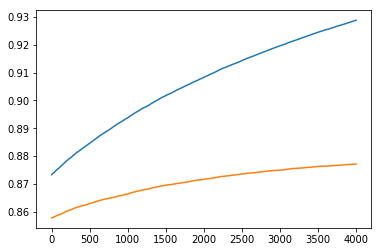

In [9]:
plt.plot(model.evals_result_['validation_0']['auc'][1000:], label='train')
plt.plot(model.evals_result_['validation_1']['auc'][1000:], label='validation');